In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seeds = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
scalings = [1.0, 1.3, 1.6, 2.0]

df_deliveries = []
df_solutions = []
df_movements = []

for seed in seeds:
    for scaling in scalings:
        df_partial = pd.read_csv("output/vrp_deliveries_d2_seed%d_scaling%.1f.csv" % (seed, scaling), sep = ";")
        df_partial["seed"] = seed
        df_partial["scaling"] = scaling
        df_deliveries.append(df_partial)

        df_partial = pd.read_csv("output/vrp_solution_d2_seed%d_scaling%.1f.csv" % (seed, scaling), sep = ";")
        df_partial["seed"] = seed
        df_partial["scaling"] = scaling
        df_solutions.append(df_partial)

        df_partial = pd.read_csv("output/vrp_movements_d2_seed%d_scaling%.1f/output_legs.csv.gz" % (seed, scaling), sep = ";")
        df_partial["seed"] = seed
        df_partial["scaling"] = scaling
        df_movements.append(df_partial)

df_deliveries = pd.concat(df_deliveries)
df_solutions = pd.concat(df_solutions)
df_movements = pd.concat(df_movements)

In [91]:
df_data = []

for scaling in scalings:
    # Households
    households = df_deliveries[
        df_deliveries["scaling"] == scaling
    ].groupby("seed")["household_id"].nunique()

    # Parcels
    parcels = df_deliveries[
        df_deliveries["scaling"] == scaling
    ].drop_duplicates(["seed", "household_id"]).groupby("seed")["packages"].sum()

    # Vehicles
    vehicles = df_solutions[
        df_solutions["scaling"] == scaling
    ].groupby("seed")["vehicle_id"].nunique()    

    # Distance
    distance = df_movements[
        df_movements["scaling"] == scaling
    ].groupby("seed")["distance"].sum()

    metrics = {
        "ahouseholds": households,
        "bparcels": parcels,
        "cvehicles": vehicles,
        "ddistance": distance * 1e-3
    }

    for name, slot in metrics.items():
        df_data.append({
            "slot": name,
            "statistic": "amean",
            "value": slot.mean(),
            "scaling": scaling
        })
        
        df_data.append({
            "slot": name,
            "statistic": "bmin",
            "value": slot.min(),
            "scaling": scaling
        })

        df_data.append({
            "slot": name,
            "statistic": "cmax",
            "value": slot.max(),
            "scaling": scaling
        })
        
df_data = pd.DataFrame.from_records(df_data)

df_data = df_data.pivot(
    ["slot", "statistic"], "scaling"
).rename({
    "ahouseholds": "Households",
    "bparcels": "Parcels",
    "cvehicles": "Vehicles",
    "ddistance": "Distance [km]",
    "amean": "Mean",
    "bmin": "Min.",
    "cmax": "Max.",
})

df_data.index.names = ["", ""]

df_data.columns = [1.0, 1.3, 1.6, 2.0]
df_data.columns.names = ["Scaling factor"]

df_data = df_data.round(2)

#df_data.to_latex("/home/shoerl/papers/lead-synpop/results_table.tex")
df_data

Scaling factor         1.0     1.3     1.6     2.0
                                                  
Households    Mean  112.20  138.30  167.90  217.80
              Min.  101.00  121.00  147.00  186.00
              Max.  129.00  158.00  190.00  249.00
Parcels       Mean  113.50  142.30  172.30  225.40
              Min.  101.00  125.00  151.00  190.00
              Max.  129.00  165.00  198.00  259.00
Vehicles      Mean    4.10    5.00    5.40    7.40
              Min.    3.00    3.00    3.00    6.00
              Max.    6.00    6.00    7.00   10.00
Distance [km] Mean   67.64   82.95  102.42  125.02
              Min.   62.37   74.56   88.25  112.87
              Max.   76.22   96.23  127.54  150.31

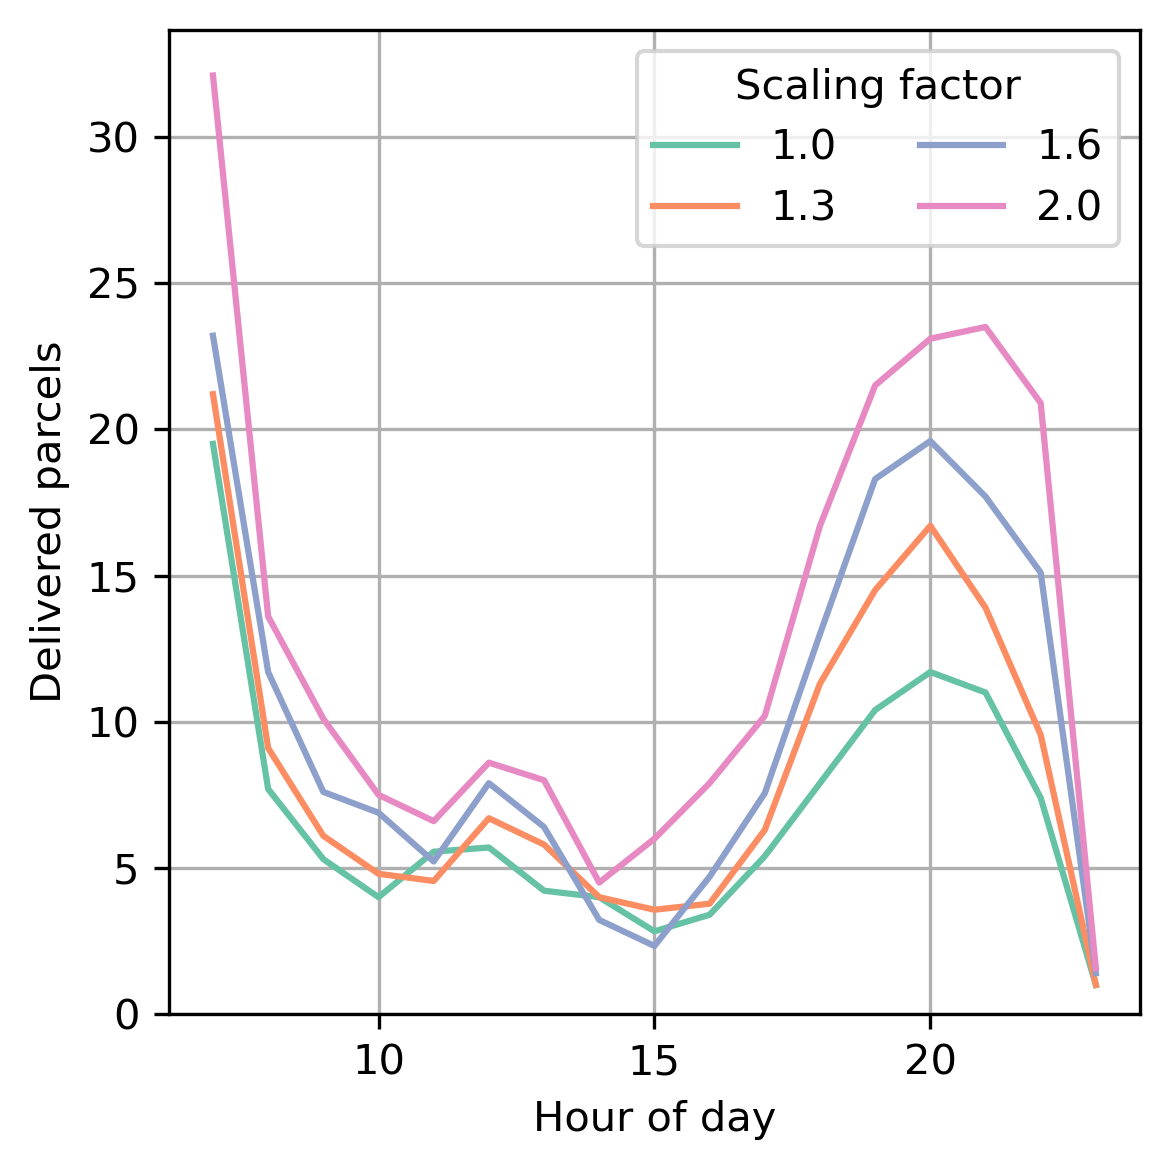

In [89]:
plt.figure(dpi = 300, figsize = (4, 4))

import palettable
colors = palettable.colorbrewer.qualitative.Set2_5.mpl_colors

for k, scaling in enumerate(scalings):
    df_time = df_solutions.copy()
    df_time = df_time[df_time["scaling"] == scaling]
    df_time = df_time[df_time["name"] == "deliverShipment"]

    q = 1

    df_time["end_bin"] = (df_time["end_time"] // (3600 / q)) * q

    df_count = df_time.groupby([
        "seed", "end_bin"
    ]).size().reset_index(name = "count").groupby("end_bin")["count"].aggregate([
        "mean", "min", "max"
    ]).reset_index()

    plt.plot(df_count["end_bin"], df_count["mean"], label = scaling, color = colors[k])
    
    #plt.fill_between(df_count["end_bin"], df_count["min"], df_count["max"], color = colors[k], alpha = 0.25,
    #                linewidth = 0.0)
    
plt.grid()

plt.legend(loc = "best", title = "Scaling factor", ncol = 2)

plt.xlabel("Hour of day")
plt.ylabel("Delivered parcels")
plt.ylim([0, None])

plt.tight_layout()
plt.savefig("parcels_by_hour.pdf")

Scaling 1.0
count     10.000000
mean     112.200000
std       10.809461
min      101.000000
25%      102.250000
50%      109.500000
75%      122.500000
max      129.000000
Name: parcels, dtype: float64
Scaling 1.3
count     10.000000
mean     138.300000
std       11.353414
min      121.000000
25%      130.750000
50%      137.500000
75%      146.500000
max      158.000000
Name: parcels, dtype: float64
Scaling 1.6
count     10.00000
mean     167.90000
std       14.50249
min      147.00000
25%      159.25000
50%      164.50000
75%      180.00000
max      190.00000
Name: parcels, dtype: float64
Scaling 2.0
count     10.000000
mean     217.800000
std       16.355767
min      186.000000
25%      210.000000
50%      219.000000
75%      221.750000
max      249.000000
Name: parcels, dtype: float64


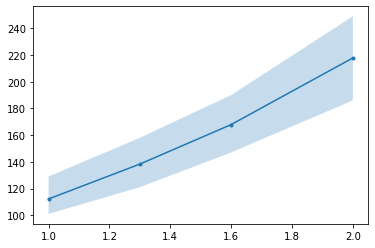

In [15]:
values = []
min_values = []
max_values = []

for scaling in scalings:
    print("Scaling", scaling)
    df_analysis = df_deliveries[
        df_deliveries["scaling"] == scaling
    ].groupby("seed")["household_id"].nunique().reset_index(name = "parcels")["parcels"]
    print(df_analysis.describe())
    
    values.append(df_analysis.mean())
    min_values.append(df_analysis.min())
    max_values.append(df_analysis.max())
    
plt.plot(scalings, values, '.-')
plt.fill_between(scalings, min_values, max_values, alpha = 0.25)

seed
1000     207
2000     208
3000     218
4000     216
5000     220
6000     186
7000     231
8000     222
9000     249
10000    221
Name: household_id, dtype: int64

In [20]:
df_deliveries[
    df_deliveries["scaling"] == scaling
].groupby("seed")["packages"].sum()

seed
1000     490.0
2000     464.0
3000     481.0
4000     505.0
5000     489.0
6000     393.0
7000     527.0
8000     501.0
9000     544.0
10000    476.0
Name: packages, dtype: float64

In [19]:
df_deliveries

,Unnamed: 0,household_id,start_time,end_time,x,y,packages,location_id,seed,scaling
0,0,1282630,25200.0,72202.0,841293.8,6517541.4,1.0,5273358484,1000,1.0
1,1,1282630,74602.0,82800.0,841293.8,6517541.4,1.0,5273358484,1000,1.0
2,2,1285478,25200.0,58332.0,841790.7,6517495.5,1.0,5947847668,1000,1.0
3,3,1285478,60132.0,82800.0,841790.7,6517495.5,1.0,5947847668,1000,1.0
4,4,1288228,25200.0,25516.0,841581.4,6517527.1,1.0,2244451870,1000,1.0
...,...,...,...,...,...,...,...,...,...,...
468,468,1292932,25200.0,82800.0,841962.1,6517818.1,1.0,5947847660,10000,2.0
469,469,1579072,25200.0,82800.0,841775.0,6518028.1,1.0,34815656,10000,2.0
470,470,1329879,25200.0,82800.0,841743.4,6517551.9,1.0,35678668,10000,2.0
471,471,1324162,25200.0,82800.0,841940.1,6517805.9,1.0,5947847660,10000,2.0


In [ ]:
values = []
min_values = []
max_values = []

for scaling in scalings:
    print("Scaling", scaling)
    df_analysis = df_deliveries[
        df_deliveries["scaling"] == scaling
    ]
    
    
    .groupby("seed")["household_id"].nunique().reset_index(name = "parcels")["parcels"]
    print(df_analysis.describe())
    
    values.append(df_analysis.mean())
    min_values.append(df_analysis.min())
    max_values.append(df_analysis.max())
    
plt.plot(scalings, values, '.-')
plt.fill_between(scalings, min_values, max_values, alpha = 0.25)

In [4]:
df_deliveries.groupby("seed")["household_id"].nunique().reset_index(name = "parcels")["parcels"].describe()

count     10.000000
mean     591.300000
std       29.706153
min      555.000000
25%      567.000000
50%      585.500000
75%      616.500000
max      639.000000
Name: parcels, dtype: float64

Scaling 1.0
count    10.000000
mean      4.100000
std       1.197219
min       3.000000
25%       3.000000
50%       4.000000
75%       4.750000
max       6.000000
Name: vehicles, dtype: float64
Scaling 1.3
count    10.000000
mean      5.000000
std       1.054093
min       3.000000
25%       4.250000
50%       5.000000
75%       6.000000
max       6.000000
Name: vehicles, dtype: float64
Scaling 1.6
count    10.000000
mean      5.400000
std       1.505545
min       3.000000
25%       4.250000
50%       5.000000
75%       7.000000
max       7.000000
Name: vehicles, dtype: float64
Scaling 2.0
count    10.000000
mean      7.400000
std       1.173788
min       6.000000
25%       7.000000
50%       7.000000
75%       8.000000
max      10.000000
Name: vehicles, dtype: float64


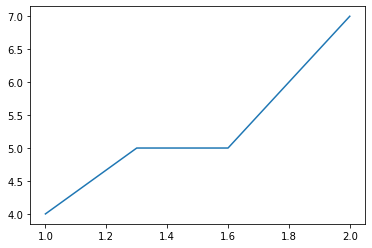

In [6]:
values = []

for scaling in scalings:
    print("Scaling", scaling)
    df_analysis = df_solutions[
        df_solutions["scaling"] == scaling
    ].groupby("seed")["vehicle_id"].nunique().reset_index(name = "vehicles")["vehicles"]
    print(df_analysis.describe())
    
    values.append(df_analysis.median())
    
plt.plot(scalings, values)

Scaling 1.0
count       10.000000
mean     67639.400000
std       4037.498131
min      62367.000000
25%      64855.500000
50%      67572.500000
75%      68827.250000
max      76219.000000
Name: distance, dtype: float64
Scaling 1.3
count       10.000000
mean     82951.200000
std       7319.692386
min      74561.000000
25%      78702.500000
50%      80509.000000
75%      87398.000000
max      96231.000000
Name: distance, dtype: float64
Scaling 1.6
count        10.000000
mean     102421.600000
std       15113.409515
min       88250.000000
25%       91883.750000
50%       96065.000000
75%      113430.750000
max      127535.000000
Name: distance, dtype: float64
Scaling 2.0
count        10.000000
mean     125019.700000
std       12569.240798
min      112866.000000
25%      117916.750000
50%      120497.500000
75%      126523.250000
max      150309.000000
Name: distance, dtype: float64


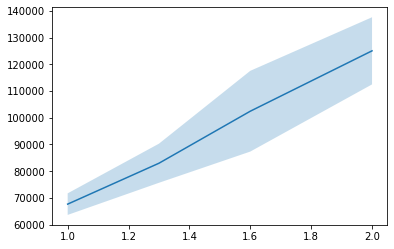

In [7]:
values = []
stds = []

for scaling in scalings:
    print("Scaling", scaling)
    df_analysis = df_movements[
        df_movements["scaling"] == scaling
    ].groupby("seed")["distance"].sum().reset_index(name = "distance")["distance"]
    print(df_analysis.describe())
    
    values.append(df_analysis.mean())
    stds.append(df_analysis.std())
    
values = np.array(values)
stds = np.array(stds)

plt.plot(scalings, values)
plt.fill_between(scalings, values - stds, values + stds, alpha = 0.25)

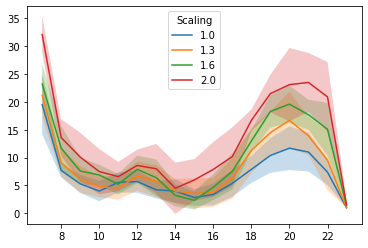

In [11]:
for scaling in scalings:
    df_time = df_solutions.copy()
    df_time = df_time[df_time["scaling"] == scaling]
    df_time = df_time[df_time["name"] == "deliverShipment"]

    q = 1

    df_time["end_bin"] = (df_time["end_time"] // (3600 / q)) * q

    df_count = df_time.groupby([
        "seed", "end_bin"
    ]).size().reset_index(name = "count").groupby("end_bin")["count"].aggregate([
        "mean", "std"
    ]).reset_index()

    plt.fill_between(
        df_count["end_bin"], df_count["mean"] - df_count["std"], df_count["mean"] + df_count["std"], alpha = 0.25)
    plt.plot(df_count["end_bin"], df_count["mean"], label = scaling)

plt.legend(loc = "best", title = "Scaling")